In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers as opt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses
import pandas as pd
import seaborn as sns
import shap

In [2]:
DATA_PATH="./Vowel_Data/Formant/"

In [3]:
seed=42

In [4]:
def get_formant(file_path):
    formant=pd.read_csv(file_path,
                delim_whitespace=True,
                header=None,
                names=["time","F1","F2","F3","F4","F5"],
                dtype=np.float64,
                na_values="--undefined--")
    return formant

def get_all_formants(path=DATA_PATH):
    labels=labels=sorted(os.listdir(path))
    all_formant=pd.DataFrame() #empty dataframe to store all_formants
    
    for label_index,label in enumerate(labels):
        folder_formant=pd.DataFrame() #empty dataframe to store formants of indivuals vowels/words i.e. folders

        formant_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(formant_files,"Reading Formants of label -'{}'".format(label)):
            #print(file)
            individual_formant=get_formant(file_path=file)
  
            length=len(individual_formant)
            F_i=individual_formant.loc[2:,'F1':'F5'].values
            F_i1=individual_formant.loc[1:length-2,'F1':'F5'].values
            F_i2=individual_formant.loc[:length-3,'F1':'F5'].values
            assert len(F_i)==len(F_i1)==len(F_i2)
            #individual_formant.loc[2:,['F1_diff2','F2_diff2','F3_diff2','F4_diff2','F5_diff2']]=np.abs(F_i-2*F_i1+F_i2)
            
            #individual_formant=individual_formant.dropna()   #drop the first two rows as there are NaN values due to the difference
            
            folder_formant=folder_formant.append(individual_formant,ignore_index=True)
        
        #folder_formant['disp(F5-F1)']=folder_formant['F5']-folder_formant['F1']
        #folder_formant['disp(F4-F3)']=folder_formant['F4']-folder_formant['F3']
        #folder_formant['disp(F5-F3)']=folder_formant['F5']-folder_formant['F3']
        #folder_formant['disp(F5-F4)']=folder_formant['F5']-folder_formant['F4']
        
        folder_formant['label']=label_index  #new columns for encoding label
        
        all_formant=all_formant.append(folder_formant,ignore_index=True)     
    return all_formant

def get_train_test(split_ratio=0.8,random_state=42):
    all_formants=get_all_formants()
    
    y=all_formants['label'].values
 
    only_formants=all_formants.drop(labels=['time','label'],axis=1)
    
    standard_formants=(only_formants-only_formants.mean())/only_formants.std()
    
    X=standard_formants.values   

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [5]:
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Formants of label -'Formant7': 100%|██████████| 40/40 [00:00<00:00, 298.32it/s]


In [6]:
np.random.seed(seed)

In [7]:
model_v=Sequential()
model_v.add(Dense(128, activation='tanh',input_shape=(X_train.shape[1],)))
model_v.add(Dense(128, activation='tanh'))
model_v.add(Dense(64, activation='tanh'))
model_v.add(Dense(32, activation='tanh'))
model_v.add(Dense(16, activation='tanh'))
model_v.add(Dense(7, activation='softmax'))

In [8]:
model_v.compile(
    optimizer=opt.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    #metrics=['AUC']#,
    metrics=[['accuracy','AUC']]
)

In [9]:
history_v=model_v.fit(X_train, y_train_hot, epochs=300, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/300
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1/1 [==============================] - 0s 434ms/step - loss: 1.9573 - accuracy: 0.1516 - auc: 0.5320 - val_loss: 1.6443 - val_accuracy: 0.3738 - val_auc: 0.7736
Epoch 2/300
1/1 [==============================] - 0s 113ms/step - loss: 1.6414 - accuracy: 0.3830 - auc: 0.7751 - val_loss: 1.5350 - val_accuracy: 0.4232 - val_auc: 0.8122
Epoch 3/300
1/1 [==============================] - 0s 89ms/step - loss: 1.5291 - accuracy: 0.4343 - auc: 0.8152 - val_loss: 1.4629 - val_accuracy: 0.4659 - val_auc: 0.8305
Epoch 4/300
1/1 [==============================] - 0s 76ms/step - loss: 1.4587 - accuracy: 0.4635 - auc: 0.8321 - val_loss: 1.4009 - val_accuracy: 0.4938 - val_auc: 0.8446
Epoch 5/300
1/1 [==============================] - 0s 162ms/step - loss: 1.3998 - accuracy: 0.4879 - auc: 0.8451 - val_loss: 1.3565 - val_accuracy: 0.5118 - val_auc: 0.8530
Epoch 6/300
1/1 [==============================] - 0s 77

1/1 [==============================] - 0s 74ms/step - loss: 0.5628 - accuracy: 0.8008 - auc: 0.9738 - val_loss: 0.5603 - val_accuracy: 0.8115 - val_auc: 0.9740
Epoch 94/300
1/1 [==============================] - 0s 83ms/step - loss: 0.5590 - accuracy: 0.8017 - auc: 0.9742 - val_loss: 0.5569 - val_accuracy: 0.8126 - val_auc: 0.9742
Epoch 95/300
1/1 [==============================] - 0s 71ms/step - loss: 0.5555 - accuracy: 0.8020 - auc: 0.9744 - val_loss: 0.5537 - val_accuracy: 0.8115 - val_auc: 0.9746
Epoch 96/300
1/1 [==============================] - 0s 79ms/step - loss: 0.5526 - accuracy: 0.8038 - auc: 0.9747 - val_loss: 0.5529 - val_accuracy: 0.8115 - val_auc: 0.9744
Epoch 97/300
1/1 [==============================] - 0s 79ms/step - loss: 0.5505 - accuracy: 0.8046 - auc: 0.9746 - val_loss: 0.5468 - val_accuracy: 0.8143 - val_auc: 0.9751
Epoch 98/300
1/1 [==============================] - 0s 83ms/step - loss: 0.5452 - accuracy: 0.8076 - auc: 0.9754 - val_loss: 0.5418 - val_accuracy: 

1/1 [==============================] - 0s 109ms/step - loss: 0.3094 - accuracy: 0.8985 - auc: 0.9913 - val_loss: 0.3535 - val_accuracy: 0.8842 - val_auc: 0.9882
Epoch 188/300
1/1 [==============================] - 0s 73ms/step - loss: 0.3071 - accuracy: 0.8987 - auc: 0.9913 - val_loss: 0.3530 - val_accuracy: 0.8863 - val_auc: 0.9882
Epoch 189/300
1/1 [==============================] - 0s 97ms/step - loss: 0.3040 - accuracy: 0.9010 - auc: 0.9915 - val_loss: 0.3538 - val_accuracy: 0.8828 - val_auc: 0.9882
Epoch 190/300
1/1 [==============================] - 0s 86ms/step - loss: 0.3031 - accuracy: 0.9008 - auc: 0.9916 - val_loss: 0.3517 - val_accuracy: 0.8870 - val_auc: 0.9881
Epoch 191/300
1/1 [==============================] - 0s 91ms/step - loss: 0.3025 - accuracy: 0.9009 - auc: 0.9916 - val_loss: 0.3541 - val_accuracy: 0.8835 - val_auc: 0.9882
Epoch 192/300
1/1 [==============================] - 0s 69ms/step - loss: 0.3005 - accuracy: 0.9009 - auc: 0.9917 - val_loss: 0.3480 - val_accu

1/1 [==============================] - 0s 120ms/step - loss: 0.1967 - accuracy: 0.9372 - auc: 0.9957 - val_loss: 0.3156 - val_accuracy: 0.9012 - val_auc: 0.9885
Epoch 282/300
1/1 [==============================] - 0s 83ms/step - loss: 0.1926 - accuracy: 0.9404 - auc: 0.9960 - val_loss: 0.3169 - val_accuracy: 0.9008 - val_auc: 0.9890
Epoch 283/300
1/1 [==============================] - 0s 74ms/step - loss: 0.1930 - accuracy: 0.9387 - auc: 0.9959 - val_loss: 0.3103 - val_accuracy: 0.9036 - val_auc: 0.9891
Epoch 284/300
1/1 [==============================] - 0s 74ms/step - loss: 0.1866 - accuracy: 0.9409 - auc: 0.9961 - val_loss: 0.3168 - val_accuracy: 0.8983 - val_auc: 0.9885
Epoch 285/300
1/1 [==============================] - 0s 104ms/step - loss: 0.1912 - accuracy: 0.9379 - auc: 0.9960 - val_loss: 0.3123 - val_accuracy: 0.9005 - val_auc: 0.9890
Epoch 286/300
1/1 [==============================] - 0s 89ms/step - loss: 0.1852 - accuracy: 0.9426 - auc: 0.9962 - val_loss: 0.3133 - val_acc

In [10]:
model_v.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 119       
Total params: 28,263
Trainable params: 28,263
Non-trainable params: 0
____________________________________________________

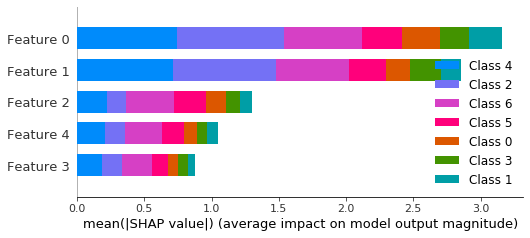

In [11]:
e=shap.DeepExplainer(model_v,X_test)
shape_values=e.shap_values(X_test)
shap.summary_plot(shape_values,X_test)

In [27]:
history_dict_v=history_v.history

loss_v=history_dict_v['loss']
val_loss_v=history_dict_v['val_loss']

acc_v=history_dict_v['accuracy']
val_acc_v=history_dict_v['val_accuracy']

auc_v=history_dict_v['auc']
val_auc_v=history_dict_v['val_auc']

In [28]:
epochs=range(1,len(loss_v)+1)
ticks=[1]
ticks2=[i for i in range(30,len(loss_v)+1,30)]
ticks.extend(ticks2)

In [47]:
save_specifier='5F_HL5_tanh_adam_005_batchfull_seed42'

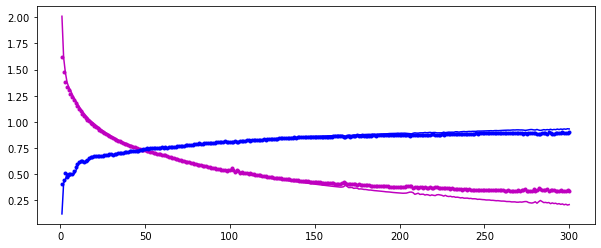

In [30]:
plt.figure(figsize=(10,4))
plt.plot(epochs,loss_v,'m', label='Training Loss')
plt.plot(epochs,val_loss_v,'m.', label='Validation Loss')

plt.plot(epochs,acc_v,'b', label='Training ACC')
plt.plot(epochs,val_acc_v,'b.', label='Validation ACC')

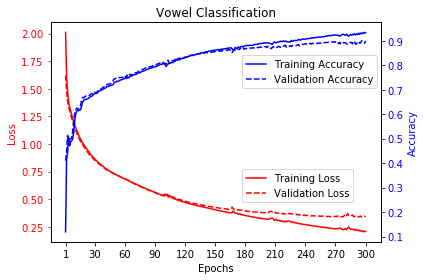

In [78]:
fig, ax=plt.subplots()
ln1=ax.plot(epochs,loss_v,'r', label='Training Loss')
ln2=ax.plot(epochs,val_loss_v,'r--', label='Validation Loss')

ax2=ax.twinx()
#ln3=ax2.plot(epochs,auc_v,'r', label='Training AUC')
#ln3=ax2.plot(epochs,val_auc_v,'o', label='Validation AUC')

ln3=ax2.plot(epochs,acc_v,'b', label='Training Accuracy')
ln3=ax2.plot(epochs,val_acc_v,'b--', label='Validation Accuracy')

ax.set_title('Vowel Classification')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
#ax2.set_ylabel('AUC - ROC')
ax2.set_ylabel('Accuracy')

plt.xticks(ticks)
ax.legend(loc=(0.58,0.18))
ax2.legend(loc=(0.58,0.7))
#fig.legend(loc=(0.6,0.4))
ax.yaxis.label.set_color('red')
ax.tick_params(axis='y', colors='red')

ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')

plt.tight_layout()
plt.savefig('./New_without_CNN/loss_acc_vowel_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [4]:
DATA_PATH="./Word_Data/Formant/"

In [21]:
def get_formant(file_path):
    formant=pd.read_csv(file_path,
                delim_whitespace=True,
                header=None,
                names=["time","F1","F2","F3","F4","F5"],
                dtype=np.float64,
                na_values="--undefined--")
    return formant

def get_all_formants(path=DATA_PATH):
    labels=labels=sorted(os.listdir(path))
    all_formant=pd.DataFrame() #empty dataframe to store all_formants
    
    for label_index,label in enumerate(labels):
        folder_formant=pd.DataFrame() #empty dataframe to store formants of indivuals vowels/words i.e. folders

        formant_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(formant_files,"Reading Formants of label -'{}'".format(label)):
            #print(file)
            individual_formant=get_formant(file_path=file)
  
            length=len(individual_formant)
            F_i=individual_formant.loc[2:,'F1':'F5'].values
            F_i1=individual_formant.loc[1:length-2,'F1':'F5'].values
            F_i2=individual_formant.loc[:length-3,'F1':'F5'].values
            assert len(F_i)==len(F_i1)==len(F_i2)
            individual_formant.loc[2:,['F1_diff2','F2_diff2','F3_diff2','F4_diff2','F5_diff2']]=np.abs(F_i-2*F_i1+F_i2)
            
            individual_formant=individual_formant.dropna()   #drop the first two rows as there are NaN values due to the difference
            
            folder_formant=folder_formant.append(individual_formant,ignore_index=True)
        
        #folder_formant['disp(F5-F1)']=folder_formant['F5']-folder_formant['F1']
        #folder_formant['disp(F4-F3)']=folder_formant['F4']-folder_formant['F3']
        #folder_formant['disp(F5-F3)']=folder_formant['F5']-folder_formant['F3']
        #folder_formant['disp(F5-F4)']=folder_formant['F5']-folder_formant['F4']
        
        folder_formant['label']=label_index  #new columns for encoding label
        
        all_formant=all_formant.append(folder_formant,ignore_index=True)     
    return all_formant

def get_train_test(split_ratio=0.8,random_state=42):
    all_formants=get_all_formants()
    
    y=all_formants['label'].values
 
    only_formants=all_formants.drop(labels=['time','label'],axis=1)
    
    standard_formants=(only_formants-only_formants.mean())/only_formants.std()
    
    X=standard_formants.values   

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [22]:
np.random.seed(seed)
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Formants of label -'Formant7': 100%|██████████| 40/40 [00:00<00:00, 84.36it/s]


In [23]:
model_w=Sequential()
model_w.add(Dense(128, activation='tanh',input_shape=(X_train.shape[1],)))
#model_w.add(Dropout(0.25))
model_w.add(Dense(128, activation='tanh'))
#model_w.add(Dropout(0.15))
model_w.add(Dense(64, activation='tanh'))
model_w.add(Dense(32, activation='tanh'))
model_w.add(Dense(16, activation='tanh'))
model_w.add(Dense(7, activation='softmax'))

In [8]:
model_w.compile(
    optimizer=opt.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    #metrics=['AUC']#,
    metrics=[['accuracy','AUC']]
)

In [9]:
history_w=model_w.fit(X_train, y_train_hot, epochs=300, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/300
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1/1 [==============================] - 0s 454ms/step - loss: 2.0306 - accuracy: 0.1328 - auc: 0.4819 - val_loss: 1.8260 - val_accuracy: 0.2664 - val_auc: 0.6638
Epoch 2/300
1/1 [==============================] - 0s 81ms/step - loss: 1.8382 - accuracy: 0.2700 - auc: 0.6551 - val_loss: 1.7318 - val_accuracy: 0.3200 - val_auc: 0.7123
Epoch 3/300
1/1 [==============================] - 0s 96ms/step - loss: 1.7414 - accuracy: 0.3215 - auc: 0.7070 - val_loss: 1.7019 - val_accuracy: 0.3228 - val_auc: 0.7274
Epoch 4/300
1/1 [==============================] - 0s 89ms/step - loss: 1.7023 - accuracy: 0.3272 - auc: 0.7270 - val_loss: 1.6834 - val_accuracy: 0.3388 - val_auc: 0.7348
Epoch 5/300
1/1 [==============================] - 0s 91ms/step - loss: 1.6830 - accuracy: 0.3383 - auc: 0.7347 - val_loss: 1.6645 - val_accuracy: 0.3517 - val_auc: 0.7423
Epoch 6/300
1/1 [==============================] - 0s 85ms

1/1 [==============================] - 0s 86ms/step - loss: 1.2549 - accuracy: 0.5175 - auc: 0.8640 - val_loss: 1.2648 - val_accuracy: 0.5190 - val_auc: 0.8620
Epoch 94/300
1/1 [==============================] - 0s 88ms/step - loss: 1.2561 - accuracy: 0.5164 - auc: 0.8637 - val_loss: 1.2627 - val_accuracy: 0.5196 - val_auc: 0.8626
Epoch 95/300
1/1 [==============================] - 0s 84ms/step - loss: 1.2522 - accuracy: 0.5164 - auc: 0.8647 - val_loss: 1.2604 - val_accuracy: 0.5203 - val_auc: 0.8631
Epoch 96/300
1/1 [==============================] - 0s 83ms/step - loss: 1.2448 - accuracy: 0.5207 - auc: 0.8664 - val_loss: 1.2590 - val_accuracy: 0.5226 - val_auc: 0.8632
Epoch 97/300
1/1 [==============================] - 0s 97ms/step - loss: 1.2444 - accuracy: 0.5192 - auc: 0.8662 - val_loss: 1.2573 - val_accuracy: 0.5213 - val_auc: 0.8636
Epoch 98/300
1/1 [==============================] - 0s 82ms/step - loss: 1.2417 - accuracy: 0.5223 - auc: 0.8671 - val_loss: 1.2546 - val_accuracy: 

1/1 [==============================] - 0s 94ms/step - loss: 1.1030 - accuracy: 0.5844 - auc: 0.8961 - val_loss: 1.1393 - val_accuracy: 0.5777 - val_auc: 0.8892
Epoch 188/300
1/1 [==============================] - 0s 93ms/step - loss: 1.0952 - accuracy: 0.5864 - auc: 0.8979 - val_loss: 1.1377 - val_accuracy: 0.5759 - val_auc: 0.8895
Epoch 189/300
1/1 [==============================] - 0s 131ms/step - loss: 1.0950 - accuracy: 0.5903 - auc: 0.8980 - val_loss: 1.1382 - val_accuracy: 0.5777 - val_auc: 0.8893
Epoch 190/300
1/1 [==============================] - 0s 84ms/step - loss: 1.1016 - accuracy: 0.5866 - auc: 0.8965 - val_loss: 1.1359 - val_accuracy: 0.5767 - val_auc: 0.8897
Epoch 191/300
1/1 [==============================] - 0s 82ms/step - loss: 1.0908 - accuracy: 0.5898 - auc: 0.8987 - val_loss: 1.1342 - val_accuracy: 0.5792 - val_auc: 0.8900
Epoch 192/300
1/1 [==============================] - 0s 85ms/step - loss: 1.0894 - accuracy: 0.5884 - auc: 0.8992 - val_loss: 1.1363 - val_accu

1/1 [==============================] - 0s 86ms/step - loss: 1.0329 - accuracy: 0.6148 - auc: 0.9095 - val_loss: 1.0902 - val_accuracy: 0.5993 - val_auc: 0.8988
Epoch 282/300
1/1 [==============================] - 0s 84ms/step - loss: 1.0264 - accuracy: 0.6114 - auc: 0.9107 - val_loss: 1.0892 - val_accuracy: 0.5990 - val_auc: 0.8990
Epoch 283/300
1/1 [==============================] - 0s 93ms/step - loss: 1.0229 - accuracy: 0.6192 - auc: 0.9112 - val_loss: 1.0897 - val_accuracy: 0.6003 - val_auc: 0.8989
Epoch 284/300
1/1 [==============================] - 0s 83ms/step - loss: 1.0178 - accuracy: 0.6197 - auc: 0.9121 - val_loss: 1.0891 - val_accuracy: 0.6013 - val_auc: 0.8991
Epoch 285/300
1/1 [==============================] - 0s 84ms/step - loss: 1.0251 - accuracy: 0.6174 - auc: 0.9108 - val_loss: 1.0896 - val_accuracy: 0.5973 - val_auc: 0.8988
Epoch 286/300
1/1 [==============================] - 0s 85ms/step - loss: 1.0226 - accuracy: 0.6158 - auc: 0.9113 - val_loss: 1.0895 - val_accur

In [10]:
history_dict_w=history_w.history
loss_w=history_dict_w['loss']
val_loss_w=history_dict_w['val_loss']

acc_w=history_dict_w['accuracy']
val_acc_w=history_dict_w['val_accuracy']

auc_w=history_dict_w['auc']
val_auc_w=history_dict_w['val_auc']

In [11]:
plt.figure(figsize=(10,4))
plt.plot(epochs_w,loss_w,'m', label='Training Loss')
plt.plot(epochs_w,val_loss_w,'m.', label='Validation Loss')

plt.plot(epochs_w,acc_w,'b', label='Training ACC')
plt.plot(epochs_w,val_acc_w,'b.', label='Validation ACC')

NameError: name 'epochs_w' is not defined

<Figure size 720x288 with 0 Axes>

In [12]:
epochs_w=range(1,len(loss_w)+1)
ticks_w=[1]
ticks2_w=[i for i in range(30,len(loss_w)+1,30)]
ticks_w.extend(ticks2_w)

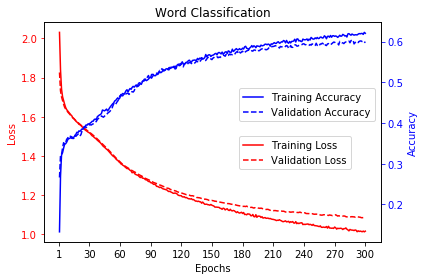

In [13]:
fig, ax=plt.subplots()
ln1=ax.plot(epochs_w,loss_w,'r', label='Training Loss')
ln2=ax.plot(epochs_w,val_loss_w,'r--', label='Validation Loss')

ax2=ax.twinx()
#ln3=ax2.plot(epochs_w,auc_w,'b', label='Training AUC')
#ln3=ax2.plot(epochs_w,val_auc_w,'b.', label='Validation AUC')

ln3=ax2.plot(epochs_w,acc_w,'b', label='Training Accuracy')
ln3=ax2.plot(epochs_w,val_acc_w,'b--', label='Validation Accuracy')

ax.set_title('Word Classification')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
#ax2.set_ylabel('AUC - ROC')
ax2.set_ylabel('Accuracy')

plt.xticks(ticks_w)
ax.legend(loc=(0.58,0.33))
ax2.legend(loc=(0.58,0.55))
#fig.legend(loc=(0.6,0.4))
ax.yaxis.label.set_color('red')
ax.tick_params(axis='y', colors='red')

ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')

plt.tight_layout()
#plt.savefig('./New_without_CNN/loss_acc_word_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [24]:
model_w.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_21 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_22 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_23 (Dense)             (None, 7)                 119       
Total params: 28,903
Trainable params: 28,903
Non-trainable params: 0
__________________________________________________

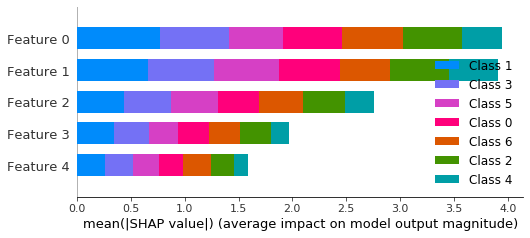

In [16]:
e=shap.DeepExplainer(model_w,X_test)
shape_values=e.shap_values(X_test)
shap.summary_plot(shape_values,X_test)

In [42]:
#COMPARE

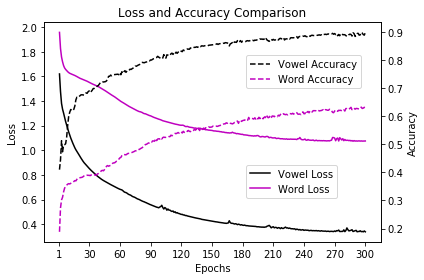

In [82]:
fig, ax=plt.subplots()
ln1=ax.plot(epochs,val_loss_v,'k', label='Vowel Loss')
ln2=ax.plot(epochs,val_loss_w,'m', label='Word Loss')

ax2=ax.twinx()
#ln3=ax2.plot(epochs,val_auc_v,'b--', label='Vowel AUC')
#ln3=ax2.plot(epochs,val_auc_w,'r--', label='Word AUC')

ln3=ax2.plot(epochs,val_acc_v,'k--', label='Vowel Accuracy')
ln3=ax2.plot(epochs,val_acc_w,'m--', label='Word Accuracy')

ax.set_title('Loss and Accuracy Comparison')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')

plt.xticks(ticks)
ax.legend(loc=(0.6,0.2))
ax2.legend(loc=(0.6,0.7))
#fig.legend(loc=(0.6,0.4))

plt.tight_layout()
plt.savefig('./New_without_CNN/comare_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [83]:
all_compare_df=pd.DataFrame({'loss_v':loss_v,
                      'val_loss_v':val_loss_v,
                      'auc_v':auc_v,
                      'val_auc_v':val_auc_v,
                      'loss_w':loss_w,
                      'val_loss_w':val_loss_w,
                      'auc_w':auc_w,
                      'val_auc_w':val_auc_w
                     })

all_compare_df.to_csv('./New_without_CNN/all_compare_data_'+save_specifier+'.csv')